# Tumour growth

In this exercise we are going to use simulated data from a model of tumour growth to investigate the identifiability of two of its parameters.

The differential equation:

\begin{equation}
\frac{dy}{dt} = \alpha (1 - \left(\frac{y}{\kappa}\right)^\nu)y,
\end{equation}

where $y(0) = y_0$ is the initial condition. This system has a solution of the form:

\begin{equation}
y(t) = \frac{\kappa}{\left(1 + \left(\left(\frac{\kappa}{y_0}\right)^\nu - 1\right)\exp(-\alpha \nu t)\right)^{1/\nu}},
\end{equation}

which results in a modified logistic-type curve that can be used to model tumour growth.

Write a function which can simulate from this model.

In [1]:
import numpy as np
import scipy
import statsmodels.api as sm
from plotnine import *
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def logistic_growth(t, alpha, nu, kappa, y0):
    Q = (kappa / y0)**nu - 1
    denom = (1 + Q * np.exp(-alpha * nu * t))**(1 / nu)
    return kappa / denom

We first assume there is no noise in the system and that the outputs are measured a 20 uniform grid points between $t=0$ and $t=20$. Generate data assuming $\alpha=1$, $\nu=2$, $\kappa=100$ and $y_0=1$.

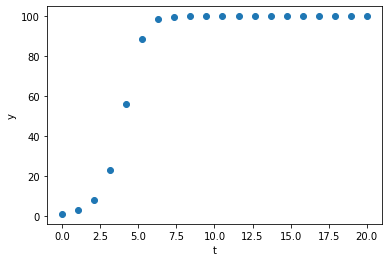

In [3]:
t = np.linspace(0, 20, 20)
y = [logistic_growth(ts, 1, 2, 100, 1) for ts in t]
plt.scatter(t, y)
plt.xlabel("t")
plt.ylabel("y")
plt.show()

Write a function which takes these outputs, $y(t)$, and determines a root-mean-square (rmse) distance from the points to a model simulation with given values of $\alpha, \nu, \kappa, y_0$. That is, we suppose there are errors:

\begin{equation}
error(t) = y(t) - \frac{\kappa}{\left(1 + \left(\left(\frac{\kappa}{y_0}\right)^\nu - 1\right)\exp(-\alpha \nu t)\right)^{1/\nu}},
\end{equation}

which result in a sum of squared errors:

\begin{equation}
sse = \sum_{t=t_1}^{t=t_T} error(t)^2,
\end{equation}

and a root-mean-square distance:

\begin{equation}
rmse = \sqrt{sse/T}.
\end{equation}

In [4]:
def rmse(y_true, t, alpha, nu, kappa, y0):
    y_sim = [logistic_growth(ts, alpha, nu, kappa, y0) for ts in t]
    y_diff = y_true - y_sim
    sse = y_diff**2
    return np.sqrt(np.mean(sse))

Using your function, plot the rmse distance as you vary $\alpha$ holding all the other parameters at their true values.

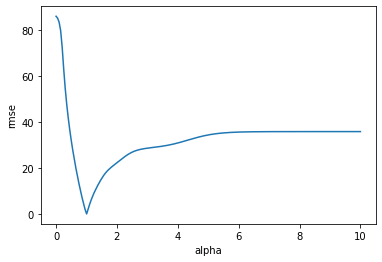

In [5]:
alpha = np.linspace(0, 10, 200)
rmses = [rmse(np.array(y), t, alphas, 2, 100, 1) for alphas in alpha]
plt.plot(alpha, rmses)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

Now repeat the same exercise for $\nu$.

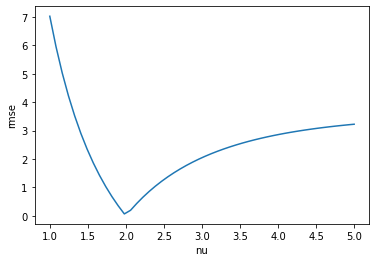

In [6]:
nu = np.linspace(1, 5)
rmses = [rmse(np.array(y), t, 1, nus, 100, 1) for nus in nu]
plt.plot(nu, rmses)
plt.xlabel("nu")
plt.ylabel("rmse")
plt.show()

Draw a contour plot visualising the rmse surface when you vary both $\alpha$ and $\nu$.

In [7]:
mesh = np.array(np.meshgrid(alpha, nu))
combinations = mesh.T.reshape(-1, 2)
df = pd.DataFrame({'alpha': combinations[:, 0], 'nu': combinations[:, 1]})
rmses = []
for i in range(len(df)):
    df_short = df.iloc[i]
    rmse_temp = rmse(np.array(y), t, df_short['alpha'], df_short['nu'], 100, 1)
    rmses.append(rmse_temp)

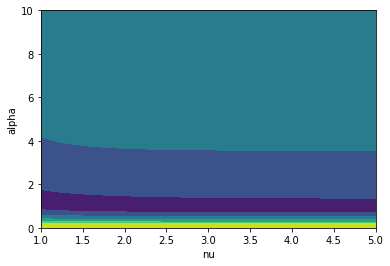

In [8]:
rmses1 = np.array(rmses)

plt.contourf(nu, alpha, np.reshape(rmses1, [len(alpha), len(nu)], order='C'))
plt.xlabel("nu")
plt.ylabel("alpha")
plt.show()

What does this plot suggest about the relative identifiability of $\alpha$ versus $\nu$?

The gradients are much stronger in the $\alpha$ direction opposed to in the $\nu$ direction, suggesting that it is likely to be better identified.

We are now going to assume that there is additive measurement noise on the data of the form:
    
\begin{equation}
\tilde y(t) \sim \text{normal}(y(t), \sigma),
\end{equation}

where $\sigma=20$.

Generate such noisy data using the same parameters and at the same time steps as before.

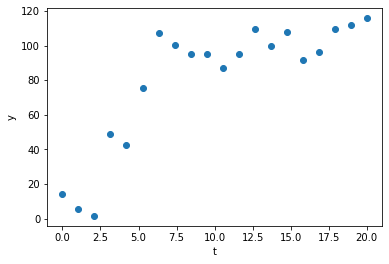

In [9]:
sigma = 10
eta = np.random.normal(0, sigma, len(t))
y_noise = y + eta
plt.scatter(t, y_noise)
plt.xlabel("t")
plt.ylabel("y")
plt.show()

Using Scipy's `minimize` function, write a function that estimates $\alpha$ and $\nu$ holding all other parameters at their true values. Then use it to estimate the parameters.

In [10]:
def rmse_2d(params):
    alpha = params[0]
    nu = params[1]
    return rmse(y_noise, t, alpha, nu, 100, 1)

def optimise(y_noise, t, kappa, y_0):
    # here I start at the true values (as a bit of a cheat)
    res = scipy.optimize.minimize(rmse_2d, [1, 2])
    estimates = res['x']
    alpha = estimates[0]
    nu = estimates[1]
    return alpha, nu

Now performing the optimisation.

In [11]:
optimise(y_noise, t, 100, 1)

(1.2785996626846425, 0.7601168389877347)

Generate 200 replicates where, in each case, you generate noisy data as before and estimate the parameters. Graph the resultant estimates for $\alpha$ and $\nu$. What does this tell you about their identifiability?

In [12]:
def generate_then_optimise(t, alpha, nu, kappa, y0, sigma):
    y = np.array([logistic_growth(ts, alpha, nu, kappa, y0) for ts in t])
    eta = np.random.normal(0, sigma, len(t))
    y_noise = y + eta
    
    def rmse_2d(params):
        alpha = params[0]
        nu = params[1]
        return rmse(y_noise, t, alpha, nu, kappa, y0)
    
    def optimise(y_noise, t, kappa, y_0):
        # here I start at the true values (as a bit of a cheat)
        res = scipy.optimize.minimize(rmse_2d, [1, 2])
        estimates = res['x']
        alpha = estimates[0]
        nu = estimates[1]
        return alpha, nu
    
    return optimise(y_noise, t, kappa, y0)

In [13]:
nreplicates = 200
alpha_est = []
nu_est = []
for i in range(nreplicates):
    alpha_temp, nu_temp = generate_then_optimise(t, 1, 2, 100, 1, 10)
    alpha_est.append(alpha_temp)
    nu_est.append(nu_temp)

/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
/Users

/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
/Users/appleuser/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
/Users/apple

It appears that $\alpha$ is much more identifiable from the data than $\nu$.

/usr/local/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 59'. Pick better value with 'binwidth'.


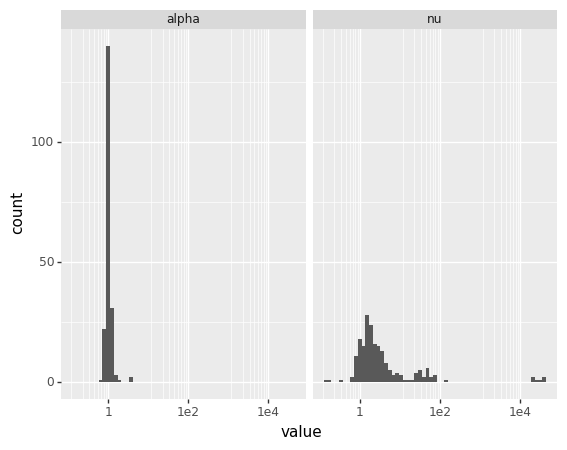

<ggplot: (347340065)>

In [14]:
df = pd.DataFrame({'alpha': alpha_est, 'nu': nu_est})
df = pd.melt(df)
(ggplot(df, aes(x='value')) +
 geom_histogram() +
 scale_x_log10() +
 facet_wrap('variable'))